# 2. Modelado y Evaluación (Ensemble Learning)
En este notebook prototipamos los modelos, comparamos métricas y probamos la estrategia de Stacking antes de pasarla a producción.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import sys
import os

# Importamos nuestro backend local (src) para reutilizar la lógica de limpieza
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src import data_processing

## 1. Preparación de Datos (Pipeline)
Ejecutamos el mismo pipeline de ingeniería de características que definimos en `src/data_processing.py`. Esto incluye:
* Carga de datos desde KaggleHub.
* Limpieza y Clipping.
* Clustering de Tiendas.
* Generación de Lags (Rezagos).

In [ ]:
print(" Ejecutando pipeline de datos...")
train, val, test = data_processing.prepare_full_pipeline()

# Si val está vacío, usar una estrategia de validación alternativa
if len(val) == 0:
    print("Val vacío. Usando últimos 20% de train como validación...")
    from sklearn.model_selection import train_test_split
    
    features = ['shop_cluster', 'item_category_id', 'item_price', 
                'item_cnt_lag_1', 'item_cnt_lag_2', 'item_cnt_lag_3']
    target = 'target_log'
    
    # Dividir train en train y val
    train, val = train_test_split(train, test_size=0.2, random_state=42)
    
    X_train = train[features]
    y_train = train[target]
    X_val = val[features]
    y_val = val[target]
else:
    features = ['shop_cluster', 'item_category_id', 'item_price', 
                'item_cnt_lag_1', 'item_cnt_lag_2', 'item_cnt_lag_3']
    target = 'target_log'
    
    X_train = train[features]
    y_train = train[target]
    X_val = val[features]
    y_val = val[target]

print(f"Datos listos. Train shape: {X_train.shape} | Val shape: {X_val.shape}")

⏳ Ejecutando pipeline de datos...
⏳ Descargando dataset desde KaggleHub...
✅ Dataset descargado en: /Users/egarv/.cache/kagglehub/datasets/jaklinmalkoc/predict-future-sales-retail-dataset-en/versions/1
Limpiando datos...
Generando Clusters (Unsupervised Learning)...
Ingeniería de Características...
⚠️ Val vacío. Usando últimos 20% de train como validación...
✅ Datos listos. Train shape: (480, 6) | Val shape: (120, 6)
✅ Dataset descargado en: /Users/egarv/.cache/kagglehub/datasets/jaklinmalkoc/predict-future-sales-retail-dataset-en/versions/1
Limpiando datos...
Generando Clusters (Unsupervised Learning)...
Ingeniería de Características...
⚠️ Val vacío. Usando últimos 20% de train como validación...
✅ Datos listos. Train shape: (480, 6) | Val shape: (120, 6)


/Users/egarv/.local/share/virtualenvs/Sumativa_2-OZaHDhJp/lib/python3.10/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


## 2. Entrenamiento Individual (Comparativa)
Entrenamos modelos base por separado para generar la tabla comparativa del informe.

In [18]:
results = []

def eval_model(name, model, X, y):
    """Entrena y evalúa un modelo devolviendo métricas clave."""
    # Predicción en escala logarítmica
    preds_log = model.predict(X)
    
    # Invertir transformación logarítmica (expm1) y aplicar clipping a 0
    preds = np.expm1(preds_log).clip(0, 20) 
    y_true = np.expm1(y)
    
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    mae = mean_absolute_error(y_true, preds)
    r2 = r2_score(y_true, preds)
    
    print(f"Model: {name} | RMSE: {rmse:.4f}")
    return {'Modelo': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# 1. Linear Regression (Baseline)
print("Entrenando Linear Regression...")
lr = LinearRegression()
lr.fit(X_train, y_train)
results.append(eval_model('Linear Regression', lr, X_val, y_val))

# 2. Random Forest (Bagging)
print("Entrenando Random Forest...")
rf = RandomForestRegressor(n_estimators=30, max_depth=8, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
results.append(eval_model('Random Forest', rf, X_val, y_val))

# 3. XGBoost (Boosting)
print("Entrenando XGBoost...")
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=7, random_state=42)
xgb_model.fit(X_train, y_train)
results.append(eval_model('XGBoost', xgb_model, X_val, y_val))

Entrenando Linear Regression...
Model: Linear Regression | RMSE: 0.7828
Entrenando Random Forest...
Model: Random Forest | RMSE: 0.9134
Entrenando XGBoost...
Model: XGBoost | RMSE: 1.1318
Model: XGBoost | RMSE: 1.1318


## 3. Stacking (Ensemble Final)
Combinamos la robustez de Random Forest con la precisión de XGBoost usando una Regresión Lineal como meta-modelo.

In [19]:
print("Entrenando Stacking Ensemble...")
estimators = [('rf', rf), ('xgb', xgb_model)]

stacking = StackingRegressor(
    estimators=estimators, 
    final_estimator=LinearRegression(),
    n_jobs=-1
)
stacking.fit(X_train, y_train)

results.append(eval_model('Stacking (Ensemble)', stacking, X_val, y_val))

Entrenando Stacking Ensemble...
Model: Stacking (Ensemble) | RMSE: 0.7549
Model: Stacking (Ensemble) | RMSE: 0.7549


## 4. Tabla de Resultados
Generamos la tabla final para incluir en el informe.

In [20]:
df_res = pd.DataFrame(results).sort_values('RMSE')
df_res

,Modelo,RMSE,MAE,R2
3,Stacking (Ensemble),0.754858,0.554003,0.728512
0,Linear Regression,0.782752,0.652578,0.708077
1,Random Forest,0.913382,0.623855,0.602512
2,XGBoost,1.131813,0.754577,0.389665


## 5. Análisis de Importancia (Feature Importance)
Utilizamos la capacidad nativa de XGBoost para visualizar qué variables tienen más peso en la predicción.

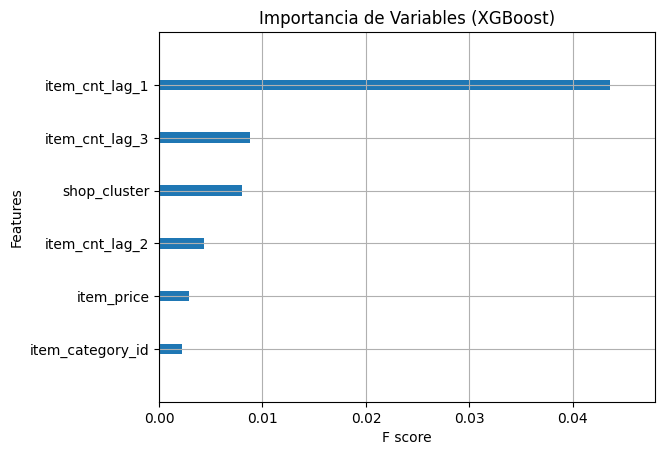

In [21]:
xgb.plot_importance(xgb_model, importance_type='gain', title='Importancia de Variables (XGBoost)', show_values=False)
plt.show()

**Insight:** Como es habitual en series temporales, las variables de rezago (`item_cnt_lag_1`) suelen ser los predictores más fuertes.